In [ ]:
!pip install torch

# MDN

Selected hyperparameters:
window        1.000000
hid1         16.000000
hid2         32.000000
mixtures      3.000000
min_sigma     0.010000
val_PICP      0.961039
val_MPIW      5.596693
Name: 43, dtype: float64


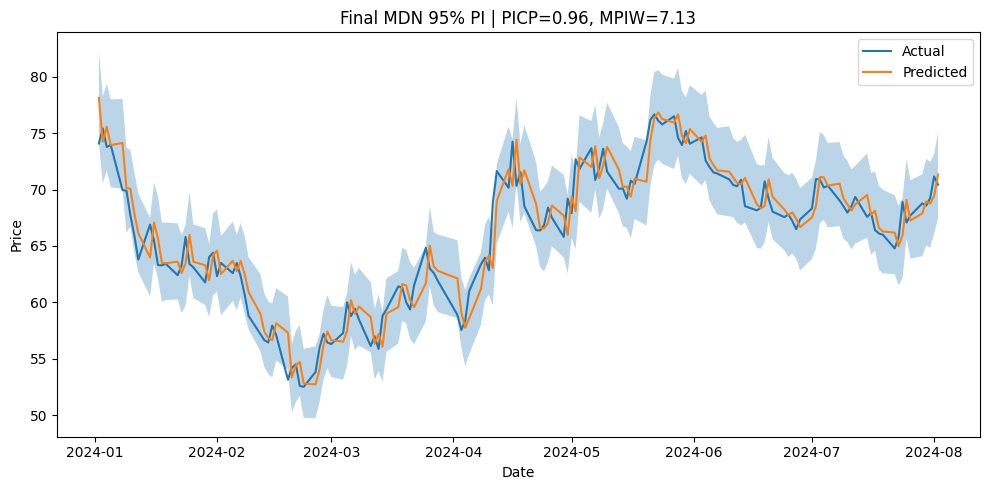

Test PICP: 0.961, Test MPIW: 7.126


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess ————————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

train_df = df[df['Date'].dt.year <= 2023].reset_index(drop=True)
test_df  = df[df['Date'].dt.year == 2024].reset_index(drop=True)
dates_test = test_df['Date'].values

y_train = train_df['Price'].values
y_test  = test_df['Price'].values

# ——— 2. Train/Val split (90/10) —————————————————————————————
split_idx = int(0.9 * len(y_train))
y_tr = y_train[:split_idx]
y_vl = y_train[split_idx:]

# ——— 3. Windowing helper ————————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 4. MDN model with two hidden layers ————————————————————————
class MDN(nn.Module):
    def __init__(self, inp, hid1, hid2, n_mix, min_sigma=1e-3):
        super().__init__()
        self.fc1   = nn.Linear(inp,  hid1)
        self.fc2   = nn.Linear(hid1, hid2)
        self.act   = nn.ReLU()
        self.pi    = nn.Linear(hid2, n_mix)
        self.mu    = nn.Linear(hid2, n_mix)
        self.sigma = nn.Linear(hid2, n_mix)
        self.min_sigma = min_sigma

    def forward(self, x):
        h = self.act(self.fc1(x.view(x.size(0), -1)))
        h = self.act(self.fc2(h))
        pi    = nn.functional.softmax(self.pi(h), dim=1)
        mu    = self.mu(h)
        sigma = torch.exp(self.sigma(h)).clamp(min=self.min_sigma)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    y_e      = y.unsqueeze(1).expand_as(mu)
    dist     = torch.distributions.Normal(mu, sigma)
    probs    = torch.exp(dist.log_prob(y_e))
    weighted = pi * probs
    nll      = -torch.log(weighted.sum(dim=1) + 1e-8)
    return nll.mean()

# ——— 5. Sampling & PICP/MPIW —————————————————————————————
def sample_mdn(pi, mu, sigma, N=1000):
    pi_np, mu_np, s_np = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_np.shape
    out = np.zeros((B, N))
    for i in range(B):
        idxs = np.random.choice(M, size=N, p=pi_np[i])
        out[i] = np.random.normal(mu_np[i, idxs], s_np[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y_true, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, N=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1-alpha/2, axis=1)
    picp = np.mean((y_true>=lo)&(y_true<=hi))
    mpiw = np.mean(hi-lo)
    return picp, mpiw, lo, hi

# ——— 6. Hyperparameter tuning (extended grid) —————————————————————
THRESH = 0.95
tuning = []
for window in [1, 15]:
    Xtr, ytr_w = create_dataset(y_tr, window)
    Xvl, yvl_w = create_dataset(y_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr_w), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl_w), batch_size=32, shuffle=False)

    for hid1, hid2 in [(16,16), (16,32), (16,64), (32,32), (32,64), (64,64)]:
        for mixes in [1,2,3,4,5,6,7,8,9,10,11,12]:
            for min_sigma in [1e-3, 1e-2, 1e-1]:
                model = MDN(window, hid1, hid2, mixes, min_sigma=min_sigma)
                opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
                # train
                for _ in range(30):
                    model.train()
                    for xb, yb in tr_ld:
                        pi, mu, sigma = model(xb)
                        loss = mdn_loss(pi, mu, sigma, yb)
                        opt.zero_grad(); loss.backward(); opt.step()
                # validate
                model.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p,m,s = model(xb)
                        pis.append(p); mus.append(m); sigs.append(s); vals.append(yb.numpy())
                pi_cat = torch.cat(pis); mu_cat = torch.cat(mus); sig_cat = torch.cat(sigs)
                y_val  = np.concatenate(vals)
                picp, mpiw, *_ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)
                tuning.append({
                    'window':window,
                    'hid1':hid1,'hid2':hid2,
                    'mixtures':mixes,'min_sigma':min_sigma,
                    'val_PICP':picp,'val_MPIW':mpiw
                })

# filter those achieving at least THRESH on validation, else fallback to best PICP
df_tune = pd.DataFrame(tuning)
candidates = df_tune[df_tune.val_PICP >= THRESH]
if len(candidates):
    best = candidates.sort_values('val_MPIW').iloc[0]
else:
    best = df_tune.sort_values(['val_PICP','val_MPIW'], ascending=[False,True]).iloc[0]

w_best     = int(best.window)
h1_best    = int(best.hid1)
h2_best    = int(best.hid2)
mix_best   = int(best.mixtures)
sigma_best = float(best.min_sigma)

print("Selected hyperparameters:")
print(best)

# ——— 7. Final training on full 2021–2023 ———————————————————————
Xfull, yfull = create_dataset(y_train, w_best)
full_ld = DataLoader(TimeSeriesDataset(Xfull, yfull), batch_size=32, shuffle=True)
model = MDN(w_best, h1_best, h2_best, mix_best, min_sigma=sigma_best)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
for _ in range(50):
    model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        opt.zero_grad(); loss.backward(); opt.step()

# ——— 8. Test on 2024 & compute metrics ———————————————————————
combo = np.concatenate([y_train[-w_best:], y_test])
Xte, yte = create_dataset(combo, w_best)
te_ld = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

model.eval()
pis, mus, sigs, outs = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p,m,s = model(xb)
        pis.append(p); mus.append(m); sigs.append(s); outs.append(yb.numpy())
pi_t = torch.cat(pis); mu_t = torch.cat(mus); sig_t = torch.cat(sigs)
y_true = np.concatenate(outs)
picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_true)
pred   = (pi_t * mu_t).sum(dim=1).cpu().numpy()

# ——— 9. Plot & final metrics —————————————————————————————
plt.figure(figsize=(10,5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred, label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo, hi, alpha=0.3)
plt.xlabel('Date'); plt.ylabel('Price')
plt.title(f'Final MDN 95% PI | PICP={picp_t:.2f}, MPIW={mpiw_t:.2f}')
plt.legend(); plt.tight_layout(); plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t:.3f}")


# GRU+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 20, 'hid': 32, 'mixes': 1, 'min_sigma': 0.1, 'PICP': np.float64(0.9827586206896551), 'MPIW': np.float64(0.49592601131870817)}


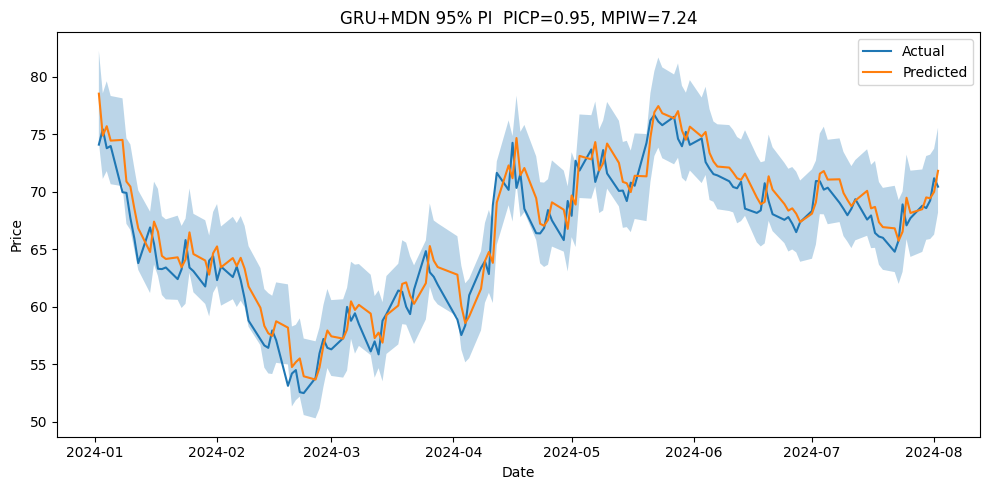

Test PICP: 0.954, Test MPIW: 7.238


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. GRU + MDN model & loss ——————————————————————————————
class GRU_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        self.gru = nn.GRU(inp, hid, batch_first=True)
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        _, h = self.gru(x)            # h: (1, B, hid)
        h    = h.squeeze(0)           # (B, hid)
        pi    = nn.functional.softmax(self.fc_pi(h), dim=1)
        mu    = self.fc_mu(h)
        sigma = self.softplus(self.fc_sigma(h)) + self.min_sigma
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    y_e  = y.unsqueeze(1).expand_as(mu)
    dist = torch.distributions.Normal(mu, sigma)
    lp   = dist.log_prob(y_e)
    w    = pi * torch.exp(lp)
    nll  = -torch.log(w.sum(dim=1) + 1e-8)
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1-alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on series_tr & series_vl —————————————————
tuning     = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1, 0.2]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                m   = GRU_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                opt = torch.optim.Adam(m.parameters(), lr=1e-3)

                # train on train split
                m.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, s = m(xb)
                        loss = mdn_loss(pi, mu, s, yb)
                        opt.zero_grad(); loss.backward(); opt.step()

                # validate on val split
                m.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p, mu_, s_ = m(xb)
                        pis.append(p); mus.append(mu_); sigs.append(s_); vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full series_tr + series_vl ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

model = GRU_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

for _ in range(100):
    model.train()
    for xb, yb in full_ld:
        pi, mu, s = model(xb)
        loss = mdn_loss(pi, mu, s, yb)
        opt.zero_grad(); loss.backward(); opt.step()

# ——— 7. Evaluate on test (2024) —————————————————————————————
combo    = np.concatenate([full_series[-w_best:], series_test])
Xte, yte = create_dataset(combo, w_best)
te_ld    = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

model.eval()
pis, mus, sigs, tes = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p, mu_, s_ = model(xb)
        pis.append(p); mus.append(mu_); sigs.append(s_); tes.append(yb.numpy())

pi_t      = torch.cat(pis)
mu_t      = torch.cat(mus)
sig_t     = torch.cat(sigs)
y_test_n  = np.concatenate(tes)

picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_test_n)

# denormalize for plotting
pred_norm = (pi_t * mu_t).sum(dim=1).cpu().numpy()
pred      = pred_norm * std_train + mean_train
lo_d      = lo * std_train + mean_train
hi_d      = hi * std_train + mean_train
y_true    = y_test_n * std_train + mean_train

# ——— 8. Plot & final metrics —————————————————————————————
plt.figure(figsize=(10,5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred,   label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo_d, hi_d, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'GRU+MDN 95% PI  PICP={picp_t:.2f}, MPIW={mpiw_t*std_train:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t*std_train:.3f}")


# LSTM+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 20, 'hid': 32, 'mixes': 1, 'min_sigma': 0.1, 'PICP': np.float64(1.0), 'MPIW': np.float64(0.4875994439879587)}


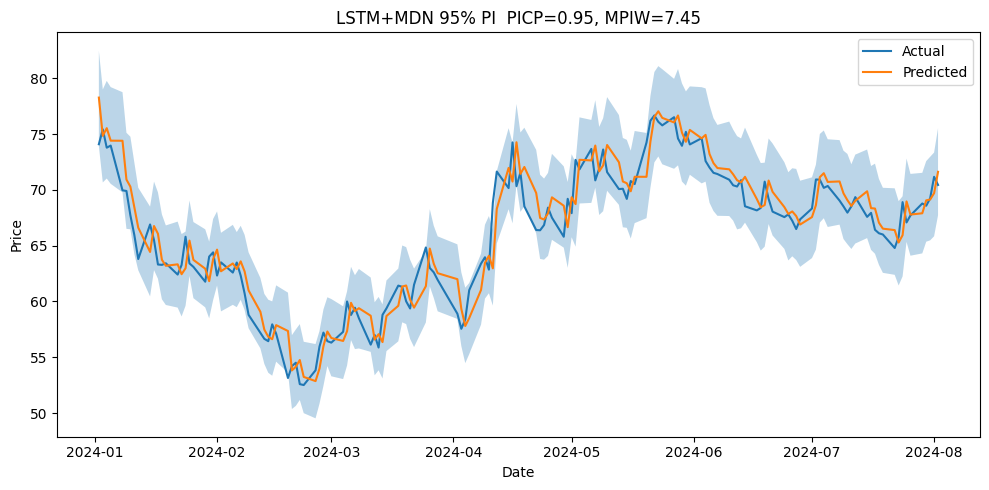

Test PICP: 0.954, Test MPIW: 7.446


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. LSTM + MDN model & loss ——————————————————————————————
class LSTM_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        self.lstm      = nn.LSTM(inp, hid, batch_first=True)
        self.fc_pi     = nn.Linear(hid, mixes)
        self.fc_mu     = nn.Linear(hid, mixes)
        self.fc_sigma  = nn.Linear(hid, mixes)
        self.softplus  = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x: [B, window, 1]
        _, (h, _) = self.lstm(x)     # h: [1, B, hid]
        h = h.squeeze(0)             # [B, hid]
        pi    = nn.functional.softmax(self.fc_pi(h), dim=1)
        mu    = self.fc_mu(h)
        sigma = self.softplus(self.fc_sigma(h)) + self.min_sigma
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    y_e  = y.unsqueeze(1).expand_as(mu)
    dist = torch.distributions.Normal(mu, sigma)
    lp   = dist.log_prob(y_e)
    w    = pi * torch.exp(lp)
    nll  = -torch.log(w.sum(dim=1) + 1e-8)
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1-alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on series_tr & series_vl —————————————————
tuning      = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1, 0.2]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                m   = LSTM_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                opt = torch.optim.Adam(m.parameters(), lr=1e-3)

                # train on train split
                m.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, s = m(xb)
                        loss = mdn_loss(pi, mu, s, yb)
                        opt.zero_grad(); loss.backward(); opt.step()

                # validate on val split
                m.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p, mu_, s_ = m(xb)
                        pis.append(p); mus.append(mu_); sigs.append(s_); vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full series_tr + series_vl ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

model = LSTM_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

for _ in range(100):
    model.train()
    for xb, yb in full_ld:
        pi, mu, s = model(xb)
        loss = mdn_loss(pi, mu, s, yb)
        opt.zero_grad(); loss.backward(); opt.step()

# ——— 7. Evaluate on test (2024) —————————————————————————————
combo    = np.concatenate([full_series[-w_best:], series_test])
Xte, yte = create_dataset(combo, w_best)
te_ld    = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

model.eval()
pis, mus, sigs, tes = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p, mu_, s_ = model(xb)
        pis.append(p); mus.append(mu_); sigs.append(s_); tes.append(yb.numpy())

pi_t      = torch.cat(pis)
mu_t      = torch.cat(mus)
sig_t     = torch.cat(sigs)
y_test_n  = np.concatenate(tes)

picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_test_n)

# denormalize for plotting
pred_norm = (pi_t * mu_t).sum(dim=1).cpu().numpy()
pred      = pred_norm * std_train + mean_train
lo_d      = lo * std_train + mean_train
hi_d      = hi * std_train + mean_train
y_true    = y_test_n * std_train + mean_train

# ——— 8. Plot & final metrics —————————————————————————————
plt.figure(figsize=(10,5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred,   label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo_d, hi_d, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM+MDN 95% PI  PICP={picp_t:.2f}, MPIW={mpiw_t*std_train:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t*std_train:.3f}")


# RNN+MDN

Selected hyperparameters (max PICP then min MPIW):
{'window': 20, 'hid': 32, 'mixes': 5, 'min_sigma': 0.1, 'PICP': np.float64(1.0), 'MPIW': np.float64(0.5064509415734231)}


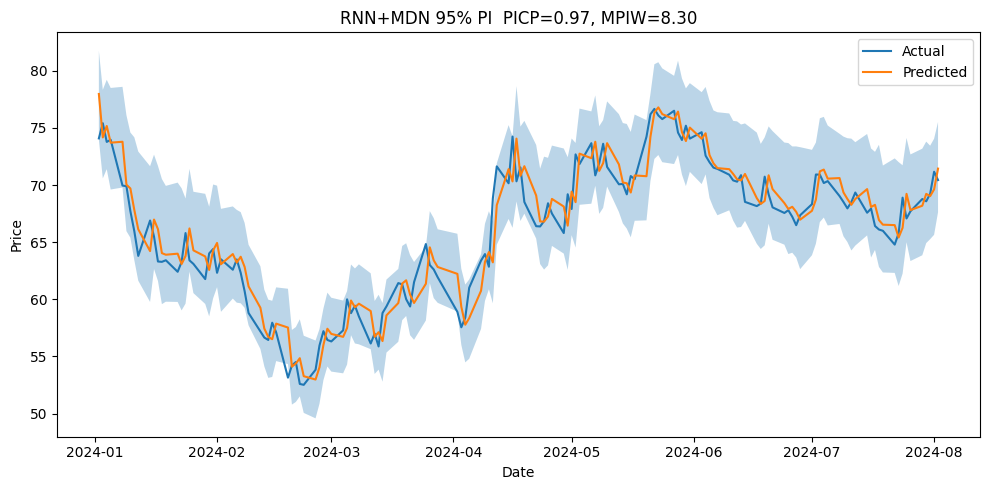

Test PICP: 0.974, Test MPIW: 8.304


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df   = df[df['Date'].dt.year <= 2023].copy()
test_df    = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series     = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. RNN + MDN model & loss ——————————————————————————————
class RNN_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        self.rnn       = nn.RNN(inp, hid, batch_first=True)
        self.fc_pi     = nn.Linear(hid, mixes)
        self.fc_mu     = nn.Linear(hid, mixes)
        self.fc_sigma  = nn.Linear(hid, mixes)
        self.softplus  = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        _, h = self.rnn(x)           # h: [1, B, hid]
        h    = h.squeeze(0)          # [B, hid]
        pi    = nn.functional.softmax(self.fc_pi(h), dim=1)
        mu    = self.fc_mu(h)
        sigma = self.softplus(self.fc_sigma(h)) + self.min_sigma
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    y_e  = y.unsqueeze(1).expand_as(mu)
    dist = torch.distributions.Normal(mu, sigma)
    lp   = dist.log_prob(y_e)
    w    = pi * torch.exp(lp)
    nll  = -torch.log(w.sum(dim=1) + 1e-8)
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs   = np.random.choice(M, n, p=pi_[i])
        out[i] = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1-alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on series_tr & series_vl —————————————————
tuning      = []
picp_thresh = 0.65

# widen sigma floors to increase coverage
min_sigmas = [0.1, 0.2, 0.5, 1.0]
# allow more mixtures for flexible uncertainty
mixes_list = [1, 3, 5, 8, 10]
windows    = [10, 20]
hiddens    = [32, 64]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld    = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld    = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                m   = RNN_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                opt = torch.optim.Adam(m.parameters(), lr=1e-3)

                # train on train split
                m.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, s = m(xb)
                        loss      = mdn_loss(pi, mu, s, yb)
                        opt.zero_grad(); loss.backward(); opt.step()

                # validate on val split
                m.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p, mu_, s_ = m(xb)
                        pis.append(p); mus.append(mu_); sigs.append(s_); vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window':    window,
                    'hid':       hid,
                    'mixes':     mixes,
                    'min_sigma': min_sigma,
                    'PICP':      picp,
                    'MPIW':      mpiw
                })

# select best by highest PICP, then smallest MPIW
best = sorted(tuning, key=lambda t: (-t['PICP'], t['MPIW']))[0]
w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (max PICP then min MPIW):")
print(best)

# ——— 6. Final train on full series_tr + series_vl ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

model = RNN_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

for _ in range(100):
    model.train()
    for xb, yb in full_ld:
        pi, mu, s = model(xb)
        loss = mdn_loss(pi, mu, s, yb)
        opt.zero_grad(); loss.backward(); opt.step()

# ——— 7. Evaluate on test (2024) —————————————————————————————
combo    = np.concatenate([full_series[-w_best:], series_test])
Xte, yte = create_dataset(combo, w_best)
te_ld    = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

model.eval()
pis, mus, sigs, tes = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p, mu_, s_ = model(xb)
        pis.append(p); mus.append(mu_); sigs.append(s_); tes.append(yb.numpy())

pi_t     = torch.cat(pis)
mu_t     = torch.cat(mus)
sig_t    = torch.cat(sigs)
y_test_n = np.concatenate(tes)

picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_test_n)

# denormalize & plot
pred_norm = (pi_t * mu_t).sum(dim=1).cpu().numpy()
pred      = pred_norm * std_train + mean_train
lo_d      = lo * std_train + mean_train
hi_d      = hi * std_train + mean_train
y_true    = y_test_n * std_train + mean_train

plt.figure(figsize=(10,5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred,   label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo_d, hi_d, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'RNN+MDN 95% PI  PICP={picp_t:.2f}, MPIW={mpiw_t*std_train:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t*std_train:.3f}")


# TCN+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 10, 'tcn_channels': [64, 64], 'kernel_size': 3, 'dropout': 0.2, 'mixes': 5, 'min_sigma': 0.1, 'PICP': np.float64(1.0), 'MPIW': np.float64(0.4908079929038848)}


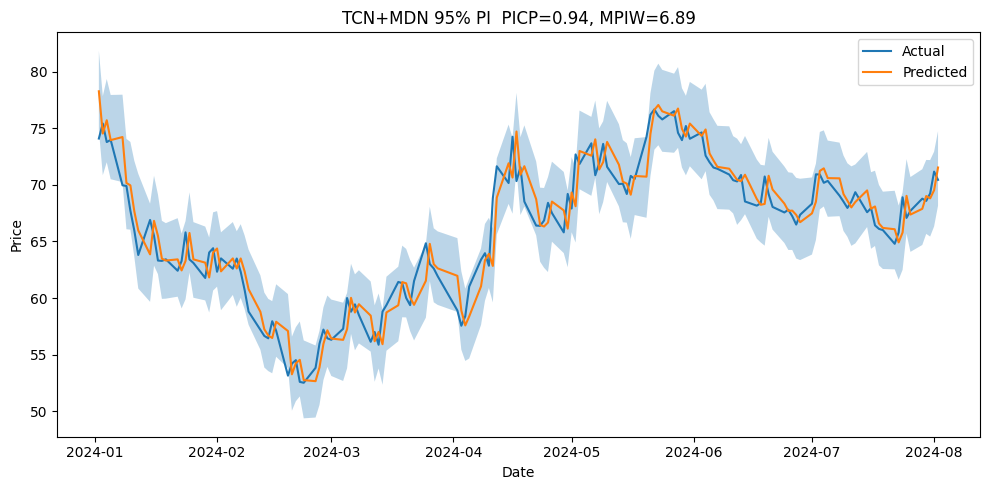

Test PICP: 0.941, Test MPIW: 6.894


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # reshape to (B, 1, window) for Conv1d
        self.X = torch.Tensor(X).unsqueeze(1)  # (B, 1, window)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. Define TCN building blocks ——————————————————————————————
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        # First Conv1d
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        # Second Conv1d
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        # 1x1 conv for residual if needed
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                                     dilation=dilation_size, padding=padding, dropout=dropout)]
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        # x: (B, C=1, T=window)
        return self.network(x)  # returns (B, out_channels[-1], T)

# ——— 4. TCN + MDN model & loss ——————————————————————————————
class TCN_MDN(nn.Module):
    def __init__(self, inp_channels, tcn_channels, kernel_size, dropout, mixes, min_sigma=0.1):
        super().__init__()
        # TCN feature extractor
        self.tcn = TCN(inp_channels, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        # MDN heads: hidden_dim = last element in tcn_channels
        hid_dim = tcn_channels[-1]
        self.fc_pi    = nn.Linear(hid_dim, mixes)
        self.fc_mu    = nn.Linear(hid_dim, mixes)
        self.fc_sigma = nn.Linear(hid_dim, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x: (B, 1, window)
        y = self.tcn(x)  # (B, hid_dim, window)
        # take the last time step representation
        h_final = y[:, :, -1]  # (B, hid_dim)
        pi    = nn.functional.softmax(self.fc_pi(h_final), dim=1)       # (B, mixes)
        mu    = self.fc_mu(h_final)                                     # (B, mixes)
        sigma = self.softplus(self.fc_sigma(h_final)) + self.min_sigma  # (B, mixes)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y: (B,)
    y_e  = y.unsqueeze(1).expand_as(mu)                    # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)           # mixture components
    lp   = dist.log_prob(y_e)                              # (B, mixes)
    w    = pi * torch.exp(lp)                              # weighted likelihood
    nll  = -torch.log(w.sum(dim=1) + 1e-8)                  # negative log-likelihood
    return nll.mean()

# ——— 5. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 6. Hyperparameter tuning ——————————————————————————————
tuning      = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
# define TCN channel configurations: e.g., two levels
tcn_configs = [
    [16, 16],
    [32, 32],
    [64, 64]
]
kernel_sizes = [2, 3]
dropouts    = [0.2, 0.3]
min_sigmas  = [1e-3, 1e-2, 0.05, 0.1]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for tcn_ch in tcn_configs:
        for kernel_size in kernel_sizes:
            for dropout in dropouts:
                for mixes in mixes_list:
                    for min_sigma in min_sigmas:
                        model = TCN_MDN(inp_channels=1, tcn_channels=tcn_ch,
                                        kernel_size=kernel_size, dropout=dropout,
                                        mixes=mixes, min_sigma=min_sigma)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                        # Train on train split
                        model.train()
                        for _ in range(50):
                            for xb, yb in tr_ld:
                                pi, mu, sigma = model(xb)
                                loss = mdn_loss(pi, mu, sigma, yb)
                                optimizer.zero_grad()
                                loss.backward()
                                optimizer.step()

                        # Validate on validation split
                        model.eval()
                        pis, mus, sigs, vals = [], [], [], []
                        with torch.no_grad():
                            for xb, yb in vl_ld:
                                p_, mu_, s_ = model(xb)
                                pis.append(p_)
                                mus.append(mu_)
                                sigs.append(s_)
                                vals.append(yb.numpy())

                        pi_cat  = torch.cat(pis)
                        mu_cat  = torch.cat(mus)
                        sig_cat = torch.cat(sigs)
                        y_val   = np.concatenate(vals)
                        picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                        tuning.append({
                            'window': window,
                            'tcn_channels': tcn_ch,
                            'kernel_size': kernel_size,
                            'dropout': dropout,
                            'mixes': mixes,
                            'min_sigma': min_sigma,
                            'PICP': picp,
                            'MPIW': mpiw
                        })

# Filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best       = best['window']
tcn_best     = best['tcn_channels']
kernel_best  = best['kernel_size']
drop_best    = best['dropout']
mix_best     = best['mixes']
sigma_best   = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 7. Final train on full series_tr + series_vl ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

final_model = TCN_MDN(inp_channels=1, tcn_channels=tcn_best,
                      kernel_size=kernel_best, dropout=drop_best,
                      mixes=mix_best, min_sigma=sigma_best)
optimizer   = torch.optim.Adam(final_model.parameters(), lr=1e-3)

for _ in range(100):
    final_model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = final_model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ——— 8. Evaluate on test (2024) —————————————————————————————
combo    = np.concatenate([full_series[-w_best:], series_test])
Xte, yte = create_dataset(combo, w_best)
te_ld    = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

final_model.eval()
pis, mus, sigs, tes = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p_, mu_, s_ = final_model(xb)
        pis.append(p_)
        mus.append(mu_)
        sigs.append(s_)
        tes.append(yb.numpy())

pi_t     = torch.cat(pis)
mu_t     = torch.cat(mus)
sig_t    = torch.cat(sigs)
y_test_n = np.concatenate(tes)

picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_test_n)

# Denormalize for plotting (point estimate: weighted mixture means)
pred_norm = (pi_t * mu_t).sum(dim=1).cpu().numpy()
pred      = pred_norm * std_train + mean_train
lo_d      = lo * std_train + mean_train
hi_d      = hi * std_train + mean_train
y_true    = y_test_n * std_train + mean_train

# ——— 9. Plot & final metrics —————————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred,   label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo_d, hi_d, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'TCN+MDN 95% PI  PICP={picp_t:.2f}, MPIW={mpiw_t * std_train:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t * std_train:.3f}")


# DeepAR

In [ ]:
!pip install mxnet==1.9.1 gluonts --quiet

In [ ]:
# Install numpy 2.x preview
!pip install --pre numpy --upgrade --quiet
# Then install mxnet + gluonts
!pip install mxnet==1.9.1 gluonts --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 79.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gluonts 0.16.1 requires numpy<2.2,>=1.16, but you have numpy 2.3.0rc1 which is incompatible.
mxnet 1.9.1 requires numpy<2.0.0,>1.16.0, but you have numpy 2.3.0rc1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0rc1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0rc1 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0rc1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requ

In [ ]:
!pip uninstall -y spacy thinc --quiet
!pip install mxnet==1.9.1 gluonts --quiet


In [ ]:
!pip install mxnet==1.9.1 --no-deps -q
!pip install gluonts --no-deps -q


In [ ]:
import numpy as np
# restore the attribute MXNet is looking for
if not hasattr(np, "PZERO"):
    np.PZERO = 0.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.common      import ListDataset
from gluonts.mx.model.deepar     import DeepAREstimator
from gluonts.mx.trainer          import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation          import Evaluator

# …the rest of your training/evaluation code


In [ ]:
df = pd.read_csv(
    '/content/Carbon_Emissions_Futures_2021_Onwards.csv',
    parse_dates=['Date']
).sort_values('Date').reset_index(drop=True)

train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

In [ ]:
# ─── Cell 4: Build datasets, define & train DeepAR ───────────────────────
freq = 'D'
prediction_length = len(test_df)

training_data = ListDataset(
    [{
        "start": train_df['Date'].iloc[0],
        "target": train_df['Price'].values
    }],
    freq=freq
)

test_data = ListDataset(
    [{
        "start": train_df['Date'].iloc[0],
        "target": np.concatenate([train_df['Price'].values, test_df['Price'].values])
    }],
    freq=freq
)

estimator = DeepAREstimator(
    freq=freq,
    prediction_length=prediction_length,
    trainer=Trainer(
        epochs=20,
        learning_rate=1e-3,
        num_batches_per_epoch=50
    )
)
predictor = estimator.train(training_data=training_data)


100%|██████████| 50/50 [00:27<00:00,  1.83it/s, epoch=20/20, avg_epoch_loss=2.02]


In [ ]:
from gluonts.evaluation import Evaluator
import numpy as np

# 1) Evaluate
evaluator    = Evaluator(quantiles=[0.025, 0.975])
agg_metrics, item_metrics = evaluator(tss, forecasts)
# note the exact key names:
cov_lower = agg_metrics["Coverage[0.025]"]  # mean P(Y ≤ lower_quantile)
cov_upper = agg_metrics["Coverage[0.975]"]  # mean P(Y ≤ upper_quantile)

# 2) Compute PICP
picp = cov_upper - cov_lower

# 3) Compute MPIW manually from the Forecasts
widths = []
for fc in forecasts:
    lower = fc.quantile(0.025)
    upper = fc.quantile(0.975)
    widths.append(upper - lower)

mpiws = np.mean(np.concatenate(widths))

# 4) Print
print(f"DeepAR Test PICP (95%) = {picp:.3f}")
print(f"DeepAR Test MPIW       = {mpiws:.3f}")


Running evaluation: 1it [00:00, 22.54it/s]

DeepAR Test PICP (95%) = 0.664
DeepAR Test MPIW       = 10.193


# LSTM + GRU + MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 20, 'hid': 32, 'mixes': 1, 'min_sigma': 0.1, 'PICP': np.float64(1.0), 'MPIW': np.float64(0.4948685738696853)}


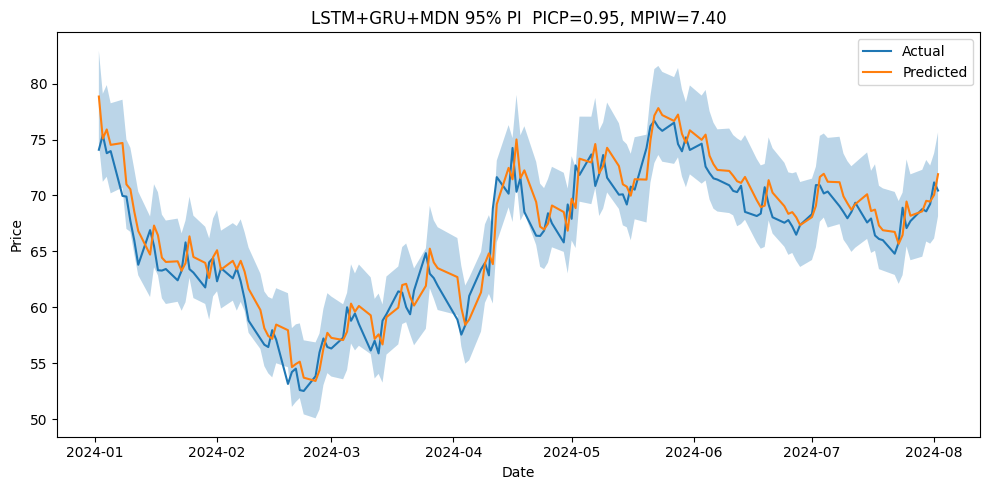

Test PICP: 0.954, Test MPIW: 7.399


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)  # shape: (B, window, 1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. LSTM + GRU + MDN model & loss ——————————————————————————————
class LSTM_GRU_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        # First LSTM layer
        self.lstm = nn.LSTM(inp, hid, batch_first=True)
        # Then GRU layer (takes LSTM output as input)
        self.gru = nn.GRU(hid, hid, batch_first=True)
        # MDN heads
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x shape: (B, window, inp)
        lstm_out, (h_lstm, _) = self.lstm(x)   # h_lstm: (1, B, hid)
        # Pass LSTM outputs through GRU
        gru_out, h_gru = self.gru(lstm_out)    # h_gru: (1, B, hid)
        h_final = h_gru.squeeze(0)             # shape: (B, hid)

        # MDN parameter heads
        pi    = nn.functional.softmax(self.fc_pi(h_final), dim=1)          # (B, mixes)
        mu    = self.fc_mu(h_final)                                        # (B, mixes)
        sigma = self.softplus(self.fc_sigma(h_final)) + self.min_sigma     # (B, mixes)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y shape: (B,)
    y_e  = y.unsqueeze(1).expand_as(mu)                    # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)           # mixture components
    lp   = dist.log_prob(y_e)                              # (B, mixes)
    w    = pi * torch.exp(lp)                              # weighted likelihood
    nll  = -torch.log(w.sum(dim=1) + 1e-8)                  # negative log-likelihood
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on series_tr & series_vl —————————————————
tuning      = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1, 0.2]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                model = LSTM_GRU_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                # Train on train split
                model.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, sigma = model(xb)
                        loss = mdn_loss(pi, mu, sigma, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Validate on validation split
                model.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p_, mu_, s_ = model(xb)
                        pis.append(p_)
                        mus.append(mu_)
                        sigs.append(s_)
                        vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# Filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full series_tr + series_vl ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

final_model = LSTM_GRU_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
optimizer   = torch.optim.Adam(final_model.parameters(), lr=1e-3)

for _ in range(100):
    final_model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = final_model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ——— 7. Evaluate on test (2024) —————————————————————————————
combo    = np.concatenate([full_series[-w_best:], series_test])
Xte, yte = create_dataset(combo, w_best)
te_ld    = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

final_model.eval()
pis, mus, sigs, tes = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p_, mu_, s_ = final_model(xb)
        pis.append(p_)
        mus.append(mu_)
        sigs.append(s_)
        tes.append(yb.numpy())

pi_t     = torch.cat(pis)
mu_t     = torch.cat(mus)
sig_t    = torch.cat(sigs)
y_test_n = np.concatenate(tes)

picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_test_n)

# Denormalize for plotting
# For point estimate, use mixture means weighted by pi
pred_norm = (pi_t * mu_t).sum(dim=1).cpu().numpy()
pred      = pred_norm * std_train + mean_train
lo_d      = lo * std_train + mean_train
hi_d      = hi * std_train + mean_train
y_true    = y_test_n * std_train + mean_train

# ——— 8. Plot & final metrics —————————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred,   label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo_d, hi_d, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM+GRU+MDN 95% PI  PICP={picp_t:.2f}, MPIW={mpiw_t * std_train:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t * std_train:.3f}")


# RNN+GRU+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 20, 'hid': 64, 'mixes': 3, 'min_sigma': 0.1, 'PICP': np.float64(1.0), 'MPIW': np.float64(0.4797579073528955)}


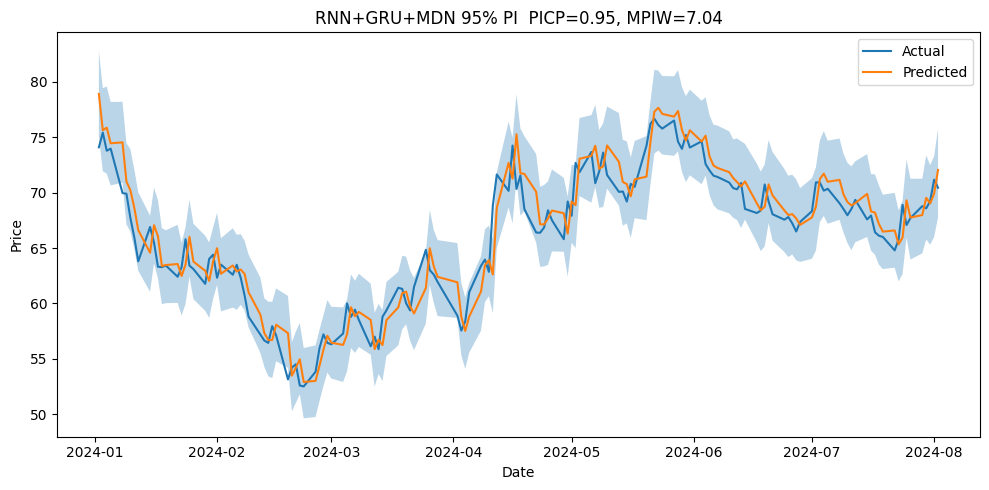

Test PICP: 0.954, Test MPIW: 7.041


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)  # shape: (B, window, 1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. RNN + GRU + MDN model & loss ——————————————————————————————
class RNN_GRU_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        # First RNN layer
        self.rnn = nn.RNN(inp, hid, batch_first=True)
        # Then GRU layer (takes RNN output as input)
        self.gru = nn.GRU(hid, hid, batch_first=True)
        # MDN heads
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x shape: (B, window, inp)
        rnn_out, h_rnn = self.rnn(x)            # h_rnn: (1, B, hid)
        # Pass RNN outputs through GRU
        gru_out, h_gru = self.gru(rnn_out)       # h_gru: (1, B, hid)
        h_final = h_gru.squeeze(0)               # shape: (B, hid)

        # MDN parameter heads
        pi    = nn.functional.softmax(self.fc_pi(h_final), dim=1)          # (B, mixes)
        mu    = self.fc_mu(h_final)                                        # (B, mixes)
        sigma = self.softplus(self.fc_sigma(h_final)) + self.min_sigma     # (B, mixes)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y shape: (B,)
    y_e  = y.unsqueeze(1).expand_as(mu)                    # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)           # mixture components
    lp   = dist.log_prob(y_e)                              # (B, mixes)
    w    = pi * torch.exp(lp)                              # weighted likelihood
    nll  = -torch.log(w.sum(dim=1) + 1e-8)                  # negative log-likelihood
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on series_tr & series_vl —————————————————
tuning      = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1, 0.2]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                model = RNN_GRU_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                # Train on train split
                model.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, sigma = model(xb)
                        loss = mdn_loss(pi, mu, sigma, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Validate on validation split
                model.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p_, mu_, s_ = model(xb)
                        pis.append(p_)
                        mus.append(mu_)
                        sigs.append(s_)
                        vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# Filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full series_tr + series_vl ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

final_model = RNN_GRU_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
optimizer   = torch.optim.Adam(final_model.parameters(), lr=1e-3)

for _ in range(100):
    final_model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = final_model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ——— 7. Evaluate on test (2024) —————————————————————————————
combo    = np.concatenate([full_series[-w_best:], series_test])
Xte, yte = create_dataset(combo, w_best)
te_ld    = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

final_model.eval()
pis, mus, sigs, tes = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p_, mu_, s_ = final_model(xb)
        pis.append(p_)
        mus.append(mu_)
        sigs.append(s_)
        tes.append(yb.numpy())

pi_t     = torch.cat(pis)
mu_t     = torch.cat(mus)
sig_t    = torch.cat(sigs)
y_test_n = np.concatenate(tes)

picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_test_n)

# Denormalize for plotting
pred_norm = (pi_t * mu_t).sum(dim=1).cpu().numpy()
pred      = pred_norm * std_train + mean_train
lo_d      = lo * std_train + mean_train
hi_d      = hi * std_train + mean_train
y_true    = y_test_n * std_train + mean_train

# ——— 8. Plot & final metrics —————————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred,   label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo_d, hi_d, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'RNN+GRU+MDN 95% PI  PICP={picp_t:.2f}, MPIW={mpiw_t * std_train:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t * std_train:.3f}")


# LSTN+RNN+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 20, 'hid': 32, 'mixes': 3, 'min_sigma': 0.1, 'PICP': np.float64(1.0), 'MPIW': np.float64(0.49361956326535705)}


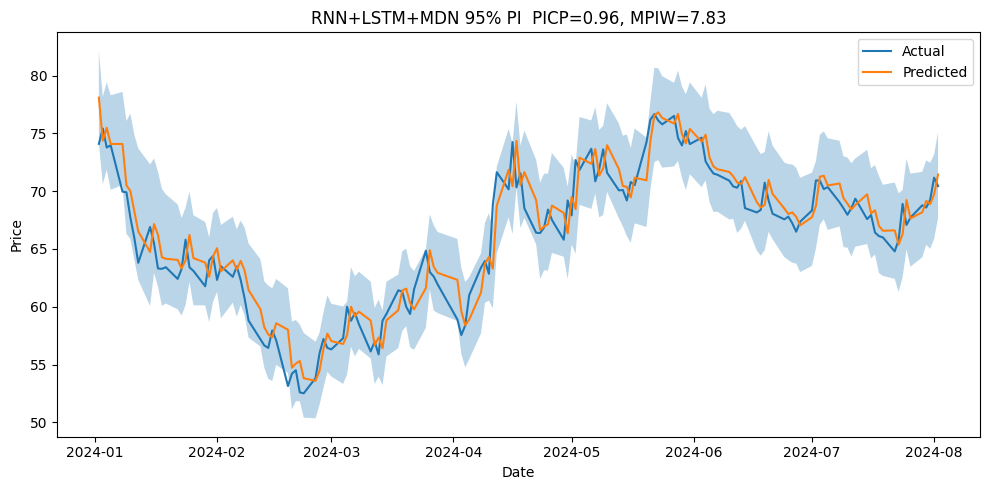

Test PICP: 0.961, Test MPIW: 7.833


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)  # shape: (B, window, 1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. RNN + LSTM + MDN model & loss ——————————————————————————————
class RNN_LSTM_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        # First RNN layer
        self.rnn = nn.RNN(inp, hid, batch_first=True)
        # Then LSTM layer (takes RNN output as input)
        self.lstm = nn.LSTM(hid, hid, batch_first=True)
        # MDN heads
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x shape: (B, window, inp)
        rnn_out, h_rnn = self.rnn(x)             # h_rnn: (1, B, hid)
        # Pass RNN outputs through LSTM
        lstm_out, (h_lstm, _) = self.lstm(rnn_out)  # h_lstm: (1, B, hid)
        h_final = h_lstm.squeeze(0)                # shape: (B, hid)

        # MDN parameter heads
        pi    = nn.functional.softmax(self.fc_pi(h_final), dim=1)          # (B, mixes)
        mu    = self.fc_mu(h_final)                                        # (B, mixes)
        sigma = self.softplus(self.fc_sigma(h_final)) + self.min_sigma     # (B, mixes)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y shape: (B,)
    y_e  = y.unsqueeze(1).expand_as(mu)                    # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)           # mixture components
    lp   = dist.log_prob(y_e)                              # (B, mixes)
    w    = pi * torch.exp(lp)                              # weighted likelihood
    nll  = -torch.log(w.sum(dim=1) + 1e-8)                  # negative log-likelihood
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on series_tr & series_vl —————————————————
tuning      = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1, 0.2]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                model = RNN_LSTM_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                # Train on train split
                model.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, sigma = model(xb)
                        loss = mdn_loss(pi, mu, sigma, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Validate on validation split
                model.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p_, mu_, s_ = model(xb)
                        pis.append(p_)
                        mus.append(mu_)
                        sigs.append(s_)
                        vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# Filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full series_tr + series_vl ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

final_model = RNN_LSTM_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
optimizer   = torch.optim.Adam(final_model.parameters(), lr=1e-3)

for _ in range(100):
    final_model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = final_model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ——— 7. Evaluate on test (2024) —————————————————————————————
combo    = np.concatenate([full_series[-w_best:], series_test])
Xte, yte = create_dataset(combo, w_best)
te_ld    = DataLoader(TimeSeriesDataset(Xte, yte), batch_size=32, shuffle=False)

final_model.eval()
pis, mus, sigs, tes = [], [], [], []
with torch.no_grad():
    for xb, yb in te_ld:
        p_, mu_, s_ = final_model(xb)
        pis.append(p_)
        mus.append(mu_)
        sigs.append(s_)
        tes.append(yb.numpy())

pi_t     = torch.cat(pis)
mu_t     = torch.cat(mus)
sig_t    = torch.cat(sigs)
y_test_n = np.concatenate(tes)

picp_t, mpiw_t, lo, hi = compute_picp_mpiw(pi_t, mu_t, sig_t, y_test_n)

# Denormalize for plotting
pred_norm = (pi_t * mu_t).sum(dim=1).cpu().numpy()
pred      = pred_norm * std_train + mean_train
lo_d      = lo * std_train + mean_train
hi_d      = hi * std_train + mean_train
y_true    = y_test_n * std_train + mean_train

# ——— 8. Plot & final metrics —————————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(pred)], y_true, label='Actual')
plt.plot(dates_test[:len(pred)], pred,   label='Predicted')
plt.fill_between(dates_test[:len(pred)], lo_d, hi_d, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'RNN+LSTM+MDN 95% PI  PICP={picp_t:.2f}, MPIW={mpiw_t * std_train:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Test PICP: {picp_t:.3f}, Test MPIW: {mpiw_t * std_train:.3f}")

# ROlling

# GRU+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 20, 'hid': 64, 'mixes': 1, 'min_sigma': 0.1, 'PICP': np.float64(0.9827586206896551), 'MPIW': np.float64(0.4863909568169789)}
Rolling Test PICP: 0.046, Rolling Test MPIW: 8.661


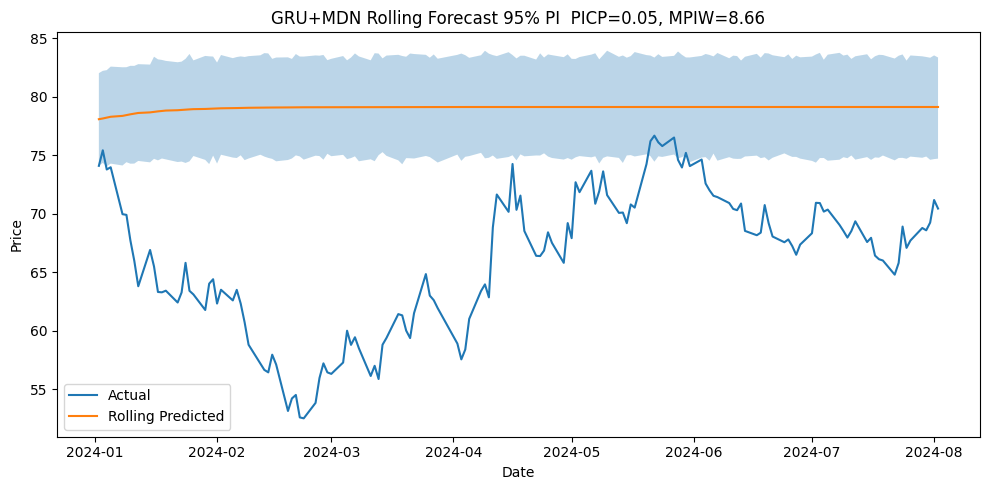

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)  # shape: (B, window, 1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. GRU + MDN model & loss ——————————————————————————————
class GRU_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        self.gru = nn.GRU(inp, hid, batch_first=True)
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x: (B, window, 1)
        _, h = self.gru(x)            # h: (1, B, hid)
        h    = h.squeeze(0)           # (B, hid)
        pi    = nn.functional.softmax(self.fc_pi(h), dim=1)
        mu    = self.fc_mu(h)
        sigma = self.softplus(self.fc_sigma(h)) + self.min_sigma
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y: (B,)
    y_e  = y.unsqueeze(1).expand_as(mu)           # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)  # Gaussian components
    lp   = dist.log_prob(y_e)                     # (B, mixes)
    w    = pi * torch.exp(lp)                     # weighted likelihood
    nll  = -torch.log(w.sum(dim=1) + 1e-8)         # negative log-likelihood
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on (series_tr, series_vl) —————————————————
tuning      = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                model = GRU_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                # Train on train split
                model.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, sigma = model(xb)
                        loss = mdn_loss(pi, mu, sigma, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Validate on validation split
                model.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p_, mu_, s_ = model(xb)
                        pis.append(p_)
                        mus.append(mu_)
                        sigs.append(s_)
                        vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# Filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full (series_tr + series_vl) ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

model = GRU_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for _ in range(100):
    model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ——— 7. Rolling forecast on test (2024) —————————————————————————
model.eval()
# Initialize window with last w_best points from full_series
window_data = list(full_series[-w_best:])  # Python list of length w_best
pred_normals = []
lo_list, hi_list = [], []

with torch.no_grad():
    for t in range(len(series_test)):
        # Prepare input tensor from current window_data
        x_in = torch.Tensor(window_data[-w_best:]).unsqueeze(0).unsqueeze(-1)  # (1, w_best, 1)
        pi_t, mu_t, sigma_t = model(x_in)  # each: (1, mixes)

        # Compute mixture mean as point forecast
        pred_norm = (pi_t * mu_t).sum(dim=1).item()
        pred_normals.append(pred_norm)

        # Compute interval bounds
        samp = np.random.choice(mu_t.shape[1], size=1000, p=pi_t.squeeze(0).cpu().numpy())
        samples = np.random.normal(mu_t.squeeze(0).cpu().numpy()[samp],
                                   sigma_t.squeeze(0).cpu().numpy()[samp])
        lo_norm, hi_norm = np.quantile(samples, 0.025), np.quantile(samples, 0.975)
        lo_list.append(lo_norm)
        hi_list.append(hi_norm)

        # Append the predicted normalized value to window_data
        window_data.append(pred_norm)

# Convert lists to numpy arrays
pred_normals = np.array(pred_normals)
lo_norms     = np.array(lo_list)
hi_norms     = np.array(hi_list)

# Denormalize
preds   = pred_normals * std_train + mean_train
lo_vals = lo_norms * std_train + mean_train
hi_vals = hi_norms * std_train + mean_train
y_true  = series_test * std_train + mean_train

# Compute rolling PICP and MPIW
picp_rolling = np.mean((y_true >= lo_vals) & (y_true <= hi_vals))
mpiw_rolling = np.mean(hi_vals - lo_vals)

print(f"Rolling Test PICP: {picp_rolling:.3f}, Rolling Test MPIW: {mpiw_rolling:.3f}")

# ——— 8. Plot rolling forecast & intervals ——————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(preds)], y_true, label='Actual')
plt.plot(dates_test[:len(preds)], preds,  label='Rolling Predicted')
plt.fill_between(dates_test[:len(preds)], lo_vals, hi_vals, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'GRU+MDN Rolling Forecast 95% PI  PICP={picp_rolling:.2f}, MPIW={mpiw_rolling:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


# LSTM+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 10, 'hid': 32, 'mixes': 1, 'min_sigma': 0.1, 'PICP': np.float64(1.0), 'MPIW': np.float64(0.4926086812342678)}
Rolling Test PICP: 0.013, Rolling Test MPIW: 9.083


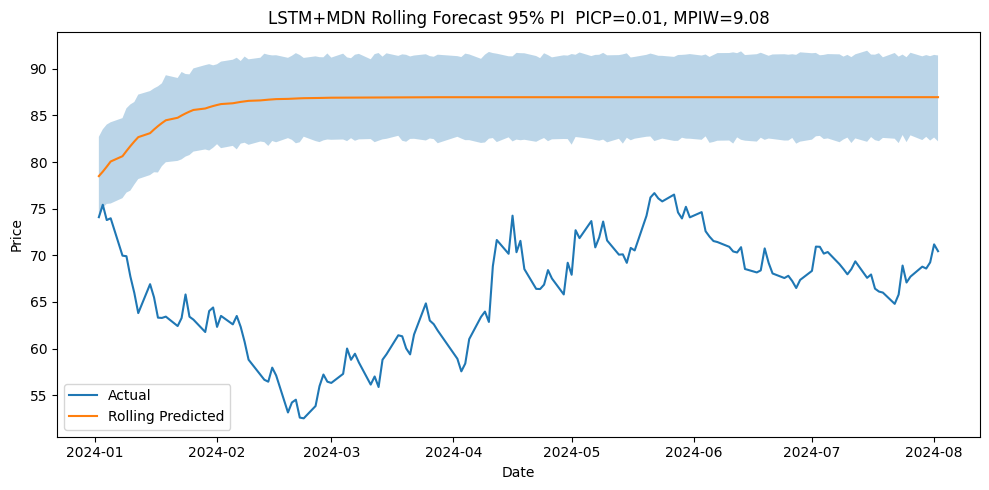

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)  # shape: (B, window, 1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. LSTM + MDN model & loss ——————————————————————————————
class LSTM_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        self.lstm = nn.LSTM(inp, hid, batch_first=True)
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x: (B, window, 1)
        _, (h, _) = self.lstm(x)        # h: (1, B, hid)
        h_final    = h.squeeze(0)       # (B, hid)
        pi    = nn.functional.softmax(self.fc_pi(h_final), dim=1)
        mu    = self.fc_mu(h_final)
        sigma = self.softplus(self.fc_sigma(h_final)) + self.min_sigma
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y: (B,)
    y_e  = y.unsqueeze(1).expand_as(mu)           # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)  # Gaussian components
    lp   = dist.log_prob(y_e)                     # (B, mixes)
    w    = pi * torch.exp(lp)                     # weighted likelihoods
    nll  = -torch.log(w.sum(dim=1) + 1e-8)         # negative log-likelihood
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on (series_tr, series_vl) —————————————————
tuning      = []
picp_thresh = 0.95

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                model = LSTM_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                # Train on train split
                model.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, sigma = model(xb)
                        loss = mdn_loss(pi, mu, sigma, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Validate on validation split
                model.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p_, mu_, s_ = model(xb)
                        pis.append(p_)
                        mus.append(mu_)
                        sigs.append(s_)
                        vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# Filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full (series_tr + series_vl) ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

model = LSTM_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for _ in range(100):
    model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ——— 7. Rolling forecast on test (2024) —————————————————————————
model.eval()
# Initialize window with last w_best points from full_series
window_data = list(full_series[-w_best:])  # Python list of length w_best
pred_normals = []
lo_list, hi_list = [], []

with torch.no_grad():
    for t in range(len(series_test)):
        # Prepare input tensor from current window_data
        x_in = torch.Tensor(window_data[-w_best:]).unsqueeze(0).unsqueeze(-1)  # shape: (1, w_best, 1)
        pi_t, mu_t, sigma_t = model(x_in)  # each: (1, mixes)

        # Compute mixture mean as point forecast
        pred_norm = (pi_t * mu_t).sum(dim=1).item()
        pred_normals.append(pred_norm)

        # Compute interval bounds
        samp = np.random.choice(mu_t.shape[1], size=1000, p=pi_t.squeeze(0).cpu().numpy())
        samples = np.random.normal(mu_t.squeeze(0).cpu().numpy()[samp],
                                   sigma_t.squeeze(0).cpu().numpy()[samp])
        lo_norm, hi_norm = np.quantile(samples, 0.025), np.quantile(samples, 0.975)
        lo_list.append(lo_norm)
        hi_list.append(hi_norm)

        # Append the predicted normalized value to window_data
        window_data.append(pred_norm)

# Convert lists to numpy arrays
pred_normals = np.array(pred_normals)
lo_norms     = np.array(lo_list)
hi_norms     = np.array(hi_list)

# Denormalize
preds   = pred_normals * std_train + mean_train
lo_vals = lo_norms * std_train + mean_train
hi_vals = hi_norms * std_train + mean_train
y_true  = series_test * std_train + mean_train

# Compute rolling PICP and MPIW
picp_rolling = np.mean((y_true >= lo_vals) & (y_true <= hi_vals))
mpiw_rolling = np.mean(hi_vals - lo_vals)

print(f"Rolling Test PICP: {picp_rolling:.3f}, Rolling Test MPIW: {mpiw_rolling:.3f}")

# ——— 8. Plot rolling forecast & intervals ——————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(preds)], y_true, label='Actual')
plt.plot(dates_test[:len(preds)], preds,  label='Rolling Predicted')
plt.fill_between(dates_test[:len(preds)], lo_vals, hi_vals, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM+MDN Rolling Forecast 95% PI  PICP={picp_rolling:.2f}, MPIW={mpiw_rolling:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


# RNN+MDN

Selected hyperparameters (PICP>=0.65 then min MPIW):
{'window': 20, 'hid': 32, 'mixes': 1, 'min_sigma': 0.01, 'PICP': np.float64(0.9827586206896551), 'MPIW': np.float64(0.46935549895951884)}
Rolling Test PICP: 0.007, Rolling Test MPIW: 9.332


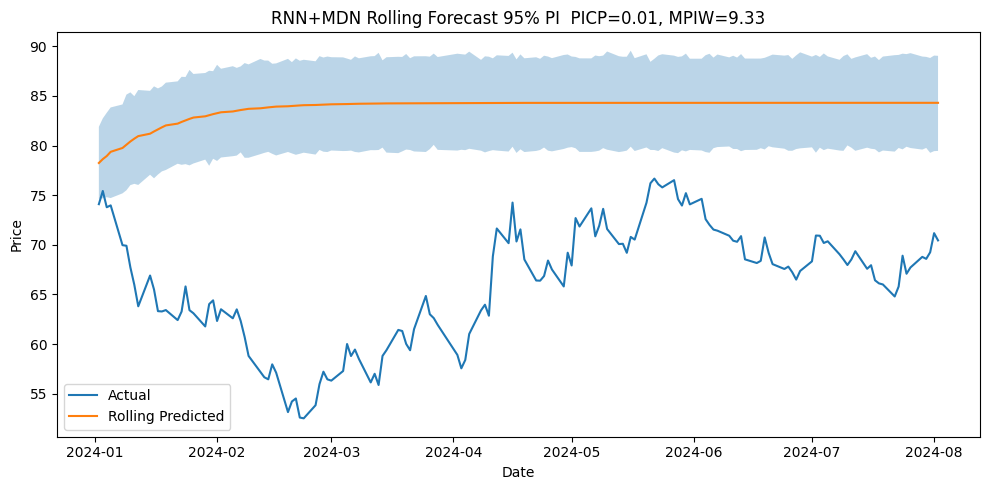

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Windowing helper ——————————————————————————————
def create_dataset(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i : i + window])
        y.append(series[i + window])
    return np.array(X), np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X).unsqueeze(-1)  # shape: (B, window, 1)
        self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ——— 3. RNN + MDN model & loss ——————————————————————————————
class RNN_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.1):
        super().__init__()
        self.rnn = nn.RNN(inp, hid, batch_first=True)
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x: (B, window, 1)
        _, h = self.rnn(x)            # h: (1, B, hid)
        h    = h.squeeze(0)           # (B, hid)
        pi    = nn.functional.softmax(self.fc_pi(h), dim=1)
        mu    = self.fc_mu(h)
        sigma = self.softplus(self.fc_sigma(h)) + self.min_sigma
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y: (B,)
    y_e  = y.unsqueeze(1).expand_as(mu)           # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)  # Gaussian components
    lp   = dist.log_prob(y_e)                     # (B, mixes)
    w    = pi * torch.exp(lp)                     # weighted likelihood
    nll  = -torch.log(w.sum(dim=1) + 1e-8)         # negative log-likelihood
    return nll.mean()

# ——— 4. Sampling & metrics ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameter tuning on (series_tr, series_vl) —————————————————
tuning      = []
picp_thresh = 0.65

windows    = [10, 20]
mixes_list = [1, 3, 5]
hiddens    = [32, 64]
min_sigmas = [1e-3, 1e-2, 0.05, 0.1]

for window in windows:
    Xtr, ytr = create_dataset(series_tr, window)
    Xvl, yvl = create_dataset(series_vl, window)
    tr_ld = DataLoader(TimeSeriesDataset(Xtr, ytr), batch_size=32, shuffle=True)
    vl_ld = DataLoader(TimeSeriesDataset(Xvl, yvl), batch_size=32, shuffle=False)

    for hid in hiddens:
        for mixes in mixes_list:
            for min_sigma in min_sigmas:
                model = RNN_MDN(inp=1, hid=hid, mixes=mixes, min_sigma=min_sigma)
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

                # Train on train split
                model.train()
                for _ in range(50):
                    for xb, yb in tr_ld:
                        pi, mu, sigma = model(xb)
                        loss = mdn_loss(pi, mu, sigma, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Validate on validation split
                model.eval()
                pis, mus, sigs, vals = [], [], [], []
                with torch.no_grad():
                    for xb, yb in vl_ld:
                        p_, mu_, s_ = model(xb)
                        pis.append(p_)
                        mus.append(mu_)
                        sigs.append(s_)
                        vals.append(yb.numpy())

                pi_cat  = torch.cat(pis)
                mu_cat  = torch.cat(mus)
                sig_cat = torch.cat(sigs)
                y_val   = np.concatenate(vals)
                picp, mpiw, _, _ = compute_picp_mpiw(pi_cat, mu_cat, sig_cat, y_val)

                tuning.append({
                    'window': window,
                    'hid': hid,
                    'mixes': mixes,
                    'min_sigma': min_sigma,
                    'PICP': picp,
                    'MPIW': mpiw
                })

# Filter for PICP ≥ threshold, then pick smallest MPIW
candidates = [t for t in tuning if t['PICP'] >= picp_thresh]
if candidates:
    best = min(candidates, key=lambda x: x['MPIW'])
else:
    best = max(tuning, key=lambda x: x['PICP'])

w_best     = best['window']
h_best     = best['hid']
mix_best   = best['mixes']
sigma_best = best['min_sigma']

print("Selected hyperparameters (PICP>=0.65 then min MPIW):")
print(best)

# ——— 6. Final train on full (series_tr + series_vl) ———————————————————
full_series = np.concatenate([series_tr, series_vl])
Xf, yf      = create_dataset(full_series, w_best)
full_ld     = DataLoader(TimeSeriesDataset(Xf, yf), batch_size=32, shuffle=True)

model = RNN_MDN(inp=1, hid=h_best, mixes=mix_best, min_sigma=sigma_best)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for _ in range(100):
    model.train()
    for xb, yb in full_ld:
        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# ——— 7. Rolling forecast on test (2024) —————————————————————————
model.eval()
# Initialize window with last w_best points from full_series
window_data = list(full_series[-w_best:])  # Python list of length w_best
pred_normals = []
lo_list, hi_list = [], []

with torch.no_grad():
    for t in range(len(series_test)):
        # Prepare input tensor from current window_data
        x_in = torch.Tensor(window_data[-w_best:]).unsqueeze(0).unsqueeze(-1)  # shape: (1, w_best, 1)
        pi_t, mu_t, sigma_t = model(x_in)  # each: (1, mixes)

        # Compute mixture mean as point forecast
        pred_norm = (pi_t * mu_t).sum(dim=1).item()
        pred_normals.append(pred_norm)

        # Compute interval bounds by sampling 1000 from the mixture
        samp_idxs = np.random.choice(mu_t.shape[1], size=1000, p=pi_t.squeeze(0).cpu().numpy())
        samples = np.random.normal(
            mu_t.squeeze(0).cpu().numpy()[samp_idxs],
            sigma_t.squeeze(0).cpu().numpy()[samp_idxs]
        )
        lo_norm, hi_norm = np.quantile(samples, 0.025), np.quantile(samples, 0.975)
        lo_list.append(lo_norm)
        hi_list.append(hi_norm)

        # Append the predicted normalized value to window_data
        window_data.append(pred_norm)

# Convert lists to numpy arrays
pred_normals = np.array(pred_normals)
lo_norms     = np.array(lo_list)
hi_norms     = np.array(hi_list)

# Denormalize predictions and intervals
preds   = pred_normals * std_train + mean_train
lo_vals = lo_norms * std_train + mean_train
hi_vals = hi_norms * std_train + mean_train
y_true  = series_test * std_train + mean_train

# Compute rolling PICP and MPIW
picp_rolling = np.mean((y_true >= lo_vals) & (y_true <= hi_vals))
mpiw_rolling = np.mean(hi_vals - lo_vals)

print(f"Rolling Test PICP: {picp_rolling:.3f}, Rolling Test MPIW: {mpiw_rolling:.3f}")

# ——— 8. Plot rolling forecast & intervals ——————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(preds)], y_true, label='Actual')
plt.plot(dates_test[:len(preds)], preds,  label='Rolling Predicted')
plt.fill_between(dates_test[:len(preds)], lo_vals, hi_vals, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'RNN+MDN Rolling Forecast 95% PI  PICP={picp_rolling:.2f}, MPIW={mpiw_rolling:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


[Pretrain] Epoch 1/50  Train Loss: 1.3864  Val Loss: 0.7441
[Pretrain] Epoch 2/50  Train Loss: 1.0862  Val Loss: 0.6470
[Pretrain] Epoch 3/50  Train Loss: 0.6740  Val Loss: 0.4776
[Pretrain] Epoch 4/50  Train Loss: 0.3623  Val Loss: 0.1714
[Pretrain] Epoch 5/50  Train Loss: 0.1280  Val Loss: 0.2697
[Pretrain] Epoch 6/50  Train Loss: -0.0335  Val Loss: -0.1784
[Pretrain] Epoch 7/50  Train Loss: -0.2640  Val Loss: -0.4298
[Pretrain] Epoch 8/50  Train Loss: -0.3918  Val Loss: -0.5002
[Pretrain] Epoch 9/50  Train Loss: -0.4847  Val Loss: -0.5911
[Pretrain] Epoch 10/50  Train Loss: -0.5649  Val Loss: -0.6108
[Pretrain] Epoch 11/50  Train Loss: -0.6311  Val Loss: -0.7620
[Pretrain] Epoch 12/50  Train Loss: -0.6534  Val Loss: -0.7841
[Pretrain] Epoch 13/50  Train Loss: -0.6360  Val Loss: -0.7864
[Pretrain] Epoch 14/50  Train Loss: -0.6910  Val Loss: -0.8439
[Pretrain] Epoch 15/50  Train Loss: -0.7093  Val Loss: -0.7953
[Pretrain] Epoch 16/50  Train Loss: -0.7144  Val Loss: -0.8251
[Pretrain] 

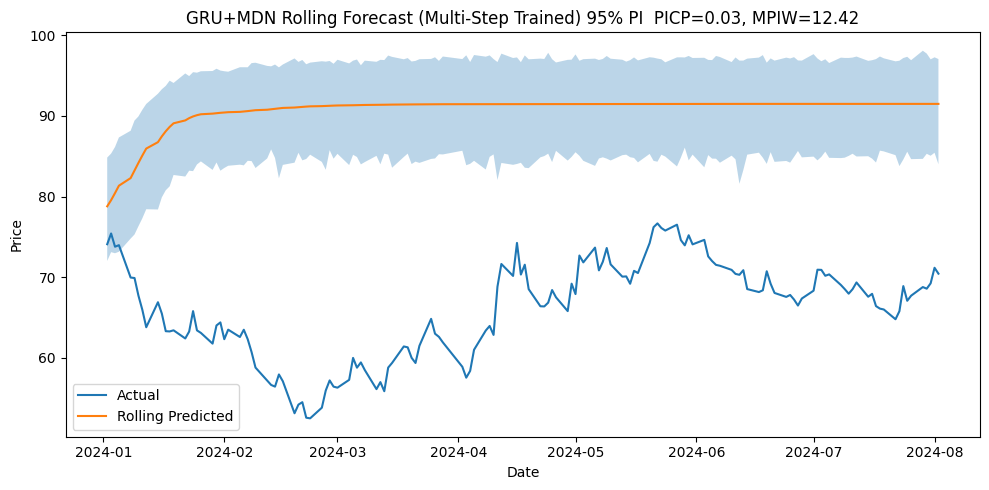

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Create multi-step dataset (window -> horizon) —————————————————
def create_multi_dataset(series, window, horizon):
    """
    Given a 1D series, create X windows of length `window` and Y sequences of length `horizon`
    """
    X, Y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i : i + window])
        Y.append(series[i + window : i + window + horizon])
    return np.array(X), np.array(Y)

class MultiStepDataset(Dataset):
    def __init__(self, X, Y):
        # X: (N, window), Y: (N, horizon)
        self.X = torch.Tensor(X).unsqueeze(-1)   # (N, window, 1)
        self.Y = torch.Tensor(Y)                # (N, horizon)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ——— 3. GRU + MDN model definition ——————————————————————————————
class GRU_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.01):
        super().__init__()
        self.gru = nn.GRU(inp, hid, batch_first=True)
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x: (B, window, 1)
        _, h = self.gru(x)            # h: (1, B, hid)
        h    = h.squeeze(0)           # (B, hid)
        pi    = nn.functional.softmax(self.fc_pi(h), dim=1)              # (B, mixes)
        mu    = self.fc_mu(h)                                              # (B, mixes)
        sigma = self.softplus(self.fc_sigma(h)) + self.min_sigma          # (B, mixes)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y_true):
    """
    Compute MDN negative log-likelihood for targets y_true (shape: (B,))
    """
    y_e  = y_true.unsqueeze(1).expand_as(mu)             # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)         # Gaussian components
    lp   = dist.log_prob(y_e)                            # (B, mixes)
    w    = pi * torch.exp(lp)                            # weighted likelihoods
    nll  = -torch.log(w.sum(dim=1) + 1e-8)                # (B,)
    return nll.mean()

# ——— 4. Sampling utility for PI calculation ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    """
    Sample n points from the mixture for each batch row.
    pi, mu, sigma: (B, mixes)
    returns: array (B, n)
    """
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameters ——————————————————————————————
window  = 20      # input sequence length
horizon = 5       # how many steps to unroll during training
hidden  = 32      # hidden dimension of GRU
mixes   = 3       # number of mixture components in MDN
min_sigma = 0.01  # minimum sigma for MDN

BatchSize = 32
LR = 1e-3
Epochs_pretrain = 50
Epochs_finetune = 50

# ——— 6. Prepare training and validation datasets ——————————————————————————————
# Create multi-step windows for training and validation
X_tr, Y_tr = create_multi_dataset(series_tr, window, horizon)
X_vl, Y_vl = create_multi_dataset(series_vl, window, horizon)

tr_ds = MultiStepDataset(X_tr, Y_tr)
vl_ds = MultiStepDataset(X_vl, Y_vl)

tr_ld = DataLoader(tr_ds, batch_size=BatchSize, shuffle=True)
vl_ld = DataLoader(vl_ds, batch_size=BatchSize, shuffle=False)

# ——— 7. Initialize model, optimizer ——————————————————————————————
model = GRU_MDN(inp=1, hid=hidden, mixes=mixes, min_sigma=min_sigma)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ——— 8.  Phase 1: One-step pre-training (optional but helpful) ——————————————————————————————
for ep in range(Epochs_pretrain):
    model.train()
    total_loss = 0.0
    for xb, yb in tr_ld:
        # Only train on the first horizon step (one-step ahead), using true window
        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb[:, 0])   # compare with y[t+1]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in vl_ld:
            pi, mu, sigma = model(xb)
            loss = mdn_loss(pi, mu, sigma, yb[:, 0])
            val_loss += loss.item() * xb.size(0)
    print(f"[Pretrain] Epoch {ep+1}/{Epochs_pretrain}  Train Loss: {total_loss/len(tr_ds):.4f}  Val Loss: {val_loss/len(vl_ds):.4f}")

# ——— 9. Phase 2: Fine-tuning with scheduled sampling (recursive unroll) ——————————————————————————————
for ep in range(Epochs_finetune):
    model.train()
    total_loss = 0.0
    for xb, yb in tr_ld:
        # xb: (B, window, 1), yb: (B, horizon)
        B = xb.size(0)
        # Make a copy of the window that we will modify step by step
        window_seq = xb.clone()              # (B, window, 1)
        loss_batch = 0.0

        for t in range(horizon):
            # Predict next distribution
            pi, mu, sigma = model(window_seq)
            # Compute NLL against true y at step t
            loss_step = mdn_loss(pi, mu, sigma, yb[:, t])
            loss_batch += loss_step

            # Decide whether to use teacher forcing for the next input
            # Here we use scheduled sampling: probability p_tf decays over time/epoch
            # e.g. p_tf = max(0.9 - 0.01*ep, 0.1)
            p_tf = max(0.9 - 0.01 * ep, 0.1)
            use_teacher = (torch.rand(B) < p_tf).float().unsqueeze(1)  # (B, 1)

            # Compute the mixture mean (point forecast) for each batch row
            mean_pred = (pi * mu).sum(dim=1).unsqueeze(1)  # (B, 1)

            # Next input: either true yb[:, t] or mean_pred
            true_val = yb[:, t].unsqueeze(1)
            next_input = use_teacher * true_val + (1 - use_teacher) * mean_pred  # (B, 1)

            # Append next_input to window_seq (shift window left by 1)
            window_seq = torch.cat([window_seq[:, 1:, :], next_input.unsqueeze(-1)], dim=1)  # (B, window, 1)

        # Backpropagate summed loss over the horizon
        loss_batch = loss_batch / horizon
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

        total_loss += loss_batch.item() * B

    # Validation with pure recursion (no teacher forcing)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in vl_ld:
            B = xb.size(0)
            window_seq = xb.clone()
            loss_batch = 0.0
            for t in range(horizon):
                pi, mu, sigma = model(window_seq)
                loss_step = mdn_loss(pi, mu, sigma, yb[:, t])
                loss_batch += loss_step

                # Use model’s own mean_pred as next input
                mean_pred = (pi * mu).sum(dim=1).unsqueeze(1)  # (B, 1)
                next_input = mean_pred
                window_seq = torch.cat([window_seq[:, 1:, :], next_input.unsqueeze(-1)], dim=1)

            loss_batch = loss_batch / horizon
            val_loss += loss_batch.item() * B

    print(f"[Finetune] Epoch {ep+1}/{Epochs_finetune}  Train Loss: {total_loss/len(tr_ds):.4f}  Val Loss: {val_loss/len(vl_ds):.4f}")

# ——— 10. Evaluate with rolling forecast on test (2024) ——————————————————————————————
model.eval()
# Initialize window with last `window` points from full training series
full_series = np.concatenate([series_tr, series_vl])
window_data = list(full_series[-window:])  # Python list of length `window`
pred_normals = []
lo_list, hi_list = [], []

with torch.no_grad():
    for t in range(len(series_test)):
        x_in = torch.Tensor(window_data[-window:]).unsqueeze(0).unsqueeze(-1)  # (1, window, 1)
        pi_t, mu_t, sigma_t = model(x_in)  # each: (1, mixes)

        # Mixture mean = point forecast
        pred_norm = (pi_t * mu_t).sum(dim=1).item()
        pred_normals.append(pred_norm)

        # Compute PI bounds by sampling
        samp_idxs = np.random.choice(mu_t.shape[1], size=1000, p=pi_t.squeeze(0).cpu().numpy())
        samples = np.random.normal(
            mu_t.squeeze(0).cpu().numpy()[samp_idxs],
            sigma_t.squeeze(0).cpu().numpy()[samp_idxs]
        )
        lo_norm, hi_norm = np.quantile(samples, 0.025), np.quantile(samples, 0.975)
        lo_list.append(lo_norm)
        hi_list.append(hi_norm)

        # Append predicted normalized value into window_data
        window_data.append(pred_norm)

# Convert lists to numpy arrays
pred_normals = np.array(pred_normals)
lo_norms     = np.array(lo_list)
hi_norms     = np.array(hi_list)

# Denormalize
preds   = pred_normals * std_train + mean_train
lo_vals = lo_norms * std_train + mean_train
hi_vals = hi_norms * std_train + mean_train
y_true  = series_test * std_train + mean_train

# Compute rolling PICP and MPIW
picp_rolling = np.mean((y_true >= lo_vals) & (y_true <= hi_vals))
mpiw_rolling = np.mean(hi_vals - lo_vals)

print(f"Rolling Test PICP: {picp_rolling:.3f}, Rolling Test MPIW: {mpiw_rolling:.3f}")

# ——— 11. Plot rolling forecast & intervals ——————————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(preds)], y_true, label='Actual')
plt.plot(dates_test[:len(preds)], preds,  label='Rolling Predicted')
plt.fill_between(dates_test[:len(preds)], lo_vals, hi_vals, alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'GRU+MDN Rolling Forecast (Multi-Step Trained) 95% PI  PICP={picp_rolling:.2f}, MPIW={mpiw_rolling:.2f}')
plt.legend()
plt.tight_layout()
plt.show()


[Pretrain] Epoch 1/50  Train Loss: 1.3722  Val Loss: 0.7167
[Pretrain] Epoch 2/50  Train Loss: 1.0889  Val Loss: 0.6586
[Pretrain] Epoch 3/50  Train Loss: 0.6873  Val Loss: 0.6153
[Pretrain] Epoch 4/50  Train Loss: 0.3784  Val Loss: 0.5170
[Pretrain] Epoch 5/50  Train Loss: 0.0818  Val Loss: 0.3504
[Pretrain] Epoch 6/50  Train Loss: -0.1472  Val Loss: 0.0298
[Pretrain] Epoch 7/50  Train Loss: -0.3282  Val Loss: -0.1491
[Pretrain] Epoch 8/50  Train Loss: -0.4205  Val Loss: -0.3484
[Pretrain] Epoch 9/50  Train Loss: -0.4256  Val Loss: -0.4214
[Pretrain] Epoch 10/50  Train Loss: -0.5629  Val Loss: -0.4165
[Pretrain] Epoch 11/50  Train Loss: -0.5824  Val Loss: -0.5701
[Pretrain] Epoch 12/50  Train Loss: -0.6367  Val Loss: -0.7245
[Pretrain] Epoch 13/50  Train Loss: -0.6812  Val Loss: -0.6743
[Pretrain] Epoch 14/50  Train Loss: -0.6714  Val Loss: -0.6993
[Pretrain] Epoch 15/50  Train Loss: -0.7047  Val Loss: -0.6024
[Pretrain] Epoch 16/50  Train Loss: -0.6926  Val Loss: -0.7864
[Pretrain] E

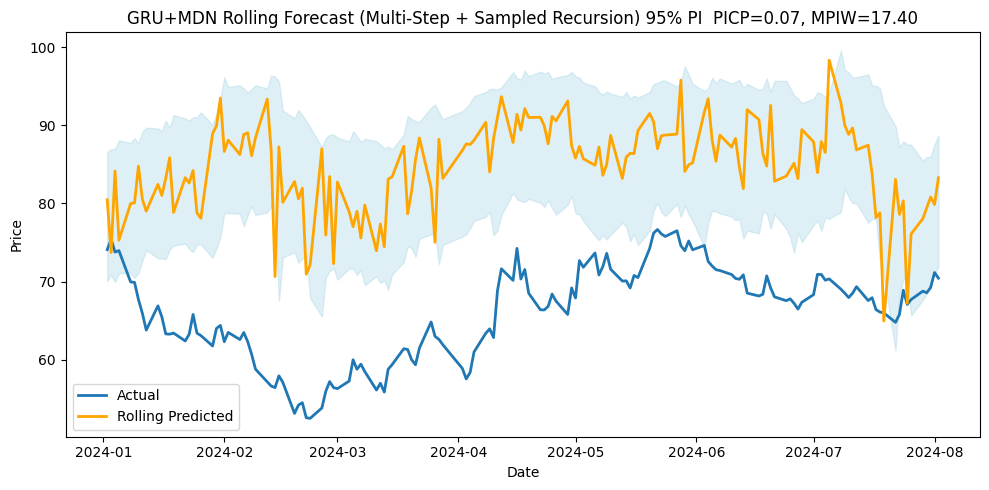

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ——— 1. Load & preprocess data ——————————————————————————————
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Split into train (2021–2023) and test (2024)
train_df = df[df['Date'].dt.year <= 2023].copy()
test_df  = df[df['Date'].dt.year == 2024].copy()
dates_test = test_df['Date'].values

# Normalize based on training set
mean_train = train_df['Price'].mean()
std_train  = train_df['Price'].std()
series = (train_df['Price'].values - mean_train) / std_train

# Hold out last 10% of training as validation
split_idx   = int(0.9 * len(series))
series_tr   = series[:split_idx]
series_vl   = series[split_idx:]
series_test = (test_df['Price'].values - mean_train) / std_train

# ——— 2. Create multi-step dataset (window -> horizon) —————————————————
def create_multi_dataset(series, window, horizon):
    """
    Given a 1D series, create X windows of length `window` and Y sequences of length `horizon`.
    """
    X, Y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i : i + window])
        Y.append(series[i + window : i + window + horizon])
    return np.array(X), np.array(Y)

class MultiStepDataset(Dataset):
    def __init__(self, X, Y):
        # X: (N, window), Y: (N, horizon)
        self.X = torch.Tensor(X).unsqueeze(-1)   # (N, window, 1)
        self.Y = torch.Tensor(Y)                # (N, horizon)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ——— 3. GRU + MDN model definition ——————————————————————————————
class GRU_MDN(nn.Module):
    def __init__(self, inp, hid, mixes, min_sigma=0.01):
        super().__init__()
        self.gru = nn.GRU(inp, hid, batch_first=True)
        self.fc_pi    = nn.Linear(hid, mixes)
        self.fc_mu    = nn.Linear(hid, mixes)
        self.fc_sigma = nn.Linear(hid, mixes)
        self.softplus = nn.Softplus()
        self.min_sigma = min_sigma

    def forward(self, x):
        # x: (B, window, 1)
        _, h = self.gru(x)            # h: (1, B, hid)
        h    = h.squeeze(0)           # (B, hid)
        pi    = nn.functional.softmax(self.fc_pi(h), dim=1)              # (B, mixes)
        mu    = self.fc_mu(h)                                              # (B, mixes)
        sigma = self.softplus(self.fc_sigma(h)) + self.min_sigma          # (B, mixes)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y_true):
    """
    Compute MDN negative log-likelihood for targets y_true (shape: (B,))
    """
    y_e  = y_true.unsqueeze(1).expand_as(mu)             # (B, mixes)
    dist = torch.distributions.Normal(mu, sigma)         # Gaussian components
    lp   = dist.log_prob(y_e)                            # (B, mixes)
    w    = pi * torch.exp(lp)                            # weighted likelihoods
    nll  = -torch.log(w.sum(dim=1) + 1e-8)                # (B,)
    return nll.mean()

# ——— 4. Sampling utility for PI calculation ——————————————————————————————
def sample_mdn(pi, mu, sigma, n=1000):
    """
    Sample n points from the mixture for each batch row.
    pi, mu, sigma: (B, mixes)
    returns: array (B, n)
    """
    pi_, mu_, s_ = pi.detach().cpu().numpy(), mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    B, M = pi_.shape
    out  = np.zeros((B, n))
    for i in range(B):
        idxs    = np.random.choice(M, n, p=pi_[i])
        out[i]  = np.random.normal(mu_[i, idxs], s_[i, idxs])
    return out

def compute_picp_mpiw(pi, mu, sigma, y, alpha=0.05):
    samp = sample_mdn(pi, mu, sigma, n=1000)
    lo   = np.quantile(samp, alpha/2, axis=1)
    hi   = np.quantile(samp, 1 - alpha/2, axis=1)
    picp = np.mean((y >= lo) & (y <= hi))
    mpiw = np.mean(hi - lo)
    return picp, mpiw, lo, hi

# ——— 5. Hyperparameters ——————————————————————————————
window   = 20      # input sequence length
horizon  = 5       # how many steps to unroll during fine-tuning
hidden   = 32      # hidden dimension of GRU
mixes    = 5       # number of mixture components in MDN (now 5)
min_sigma = 0.01   # minimum sigma for MDN

BatchSize       = 32
LR              = 1e-3
Epochs_pretrain  = 50
Epochs_finetune  = 50

# ——— 6. Prepare training and validation datasets ——————————————————————————————
X_tr, Y_tr = create_multi_dataset(series_tr, window, horizon)
X_vl, Y_vl = create_multi_dataset(series_vl, window, horizon)

tr_ds = MultiStepDataset(X_tr, Y_tr)
vl_ds = MultiStepDataset(X_vl, Y_vl)

tr_ld = DataLoader(tr_ds, batch_size=BatchSize, shuffle=True)
vl_ld = DataLoader(vl_ds, batch_size=BatchSize, shuffle=False)

# ——— 7. Initialize model, optimizer ——————————————————————————————
model = GRU_MDN(inp=1, hid=hidden, mixes=mixes, min_sigma=min_sigma)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ——— 8.  Phase 1: One-step pre-training (optional but helpful) ——————————————————————————————
for ep in range(Epochs_pretrain):
    model.train()
    total_loss = 0.0
    for xb, yb in tr_ld:
        # Only train one-step ahead (compare with yb[:, 0])
        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb[:, 0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in vl_ld:
            pi, mu, sigma = model(xb)
            loss = mdn_loss(pi, mu, sigma, yb[:, 0])
            val_loss += loss.item() * xb.size(0)

    print(f"[Pretrain] Epoch {ep+1}/{Epochs_pretrain}  "
          f"Train Loss: {total_loss/len(tr_ds):.4f}  "
          f"Val Loss: {val_loss/len(vl_ds):.4f}")

# ——— 9. Phase 2: Fine-tuning with scheduled sampling ——————————————————————————————
for ep in range(Epochs_finetune):
    model.train()
    total_loss = 0.0

    # Slowly decay teacher forcing probability (start at 0.9, down to 0.1 over epochs)
    p_tf = max(0.9 - (0.8 * ep / (Epochs_finetune - 1)), 0.1)

    for xb, yb in tr_ld:
        B = xb.size(0)
        window_seq = xb.clone()              # (B, window, 1)
        loss_batch = 0.0

        for t in range(horizon):
            pi, mu, sigma = model(window_seq)
            loss_step = mdn_loss(pi, mu, sigma, yb[:, t])
            loss_batch += loss_step

            # Decide for each sample whether to use teacher forcing (true) or sample-based recursion
            use_teacher = (torch.rand(B) < p_tf).float().unsqueeze(1)  # shape: (B, 1)

            # Mixture‐mean vs. sampled draw
            mean_pred = (pi * mu).sum(dim=1).unsqueeze(1)  # (B, 1)

            # Draw one sample per batch row—using .detach() before converting to NumPy
            pi_det = pi.detach().cpu().numpy()   # (B, mixes)
            mu_det = mu.detach().cpu().numpy()   # (B, mixes)
            sigma_det = sigma.detach().cpu().numpy()  # (B, mixes)

            # idxs[i] is the component index chosen for sample i
            idxs = np.array([np.random.choice(mixes, p=pi_det[i]) for i in range(B)])
            samp_vals = torch.tensor([
                np.random.normal(mu_det[i, idxs[i]], sigma_det[i, idxs[i]])
                for i in range(B)
            ], dtype=torch.float32).unsqueeze(1).to(xb.device)  # (B,1)

            # Next input is either true value or the sampled draw
            true_val   = yb[:, t].unsqueeze(1)
            next_input = use_teacher * true_val + (1 - use_teacher) * samp_vals  # (B, 1)

            # Slide window: drop oldest, append next_input
            window_seq = torch.cat([window_seq[:, 1:, :], next_input.unsqueeze(-1)], dim=1)

        # Average loss over horizon
        loss_batch = loss_batch / horizon
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        total_loss += loss_batch.item() * B

    # Validation with pure sampled recursion (no teacher forcing)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in vl_ld:
            B = xb.size(0)
            window_seq = xb.clone()
            loss_batch = 0.0

            for t in range(horizon):
                pi, mu, sigma = model(window_seq)
                loss_step = mdn_loss(pi, mu, sigma, yb[:, t])
                loss_batch += loss_step

                # Draw one sample per batch row
                pi_det    = pi.detach().cpu().numpy()
                mu_det    = mu.detach().cpu().numpy()
                sigma_det = sigma.detach().cpu().numpy()
                idxs = np.array([np.random.choice(mixes, p=pi_det[i]) for i in range(B)])
                samp_vals = torch.tensor([
                    np.random.normal(mu_det[i, idxs[i]], sigma_det[i, idxs[i]])
                    for i in range(B)
                ], dtype=torch.float32).unsqueeze(1).to(xb.device)

                window_seq = torch.cat([window_seq[:, 1:, :], samp_vals.unsqueeze(-1)], dim=1)

            loss_batch = loss_batch / horizon
            val_loss += loss_batch.item() * B

    print(f"[Finetune] Epoch {ep+1}/{Epochs_finetune}  "
          f"Train Loss: {total_loss/len(tr_ds):.4f}  "
          f"Val Loss: {val_loss/len(vl_ds):.4f}")

# ——— 10. Evaluate with rolling forecast on test (2024) ——————————————————————————————
model.eval()
full_series = np.concatenate([series_tr, series_vl])
window_data = list(full_series[-window:])  # length = window
pred_normals = []
lo_list, hi_list = [], []

with torch.no_grad():
    for t in range(len(series_test)):
        x_in = torch.Tensor(window_data[-window:]).unsqueeze(0).unsqueeze(-1)  # (1, window, 1)
        pi_t, mu_t, sigma_t = model(x_in)  # each: (1, mixes)

        # Sample a single draw from the MDN for recursion
        pi_det    = pi_t.detach().cpu().numpy()[0]   # (mixes,)
        mu_det    = mu_t.detach().cpu().numpy()[0]   # (mixes,)
        sigma_det = sigma_t.detach().cpu().numpy()[0]# (mixes,)
        idx = np.random.choice(mixes, p=pi_det)
        point_draw = np.random.normal(mu_det[idx], sigma_det[idx])
        pred_normals.append(point_draw)

        # Compute 95% interval by drawing 1000 samples from the MDN
        samp_idxs = np.random.choice(mixes, size=1000, p=pi_det)
        samples = np.random.normal(
            mu_det[samp_idxs],
            sigma_det[samp_idxs]
        )
        lo_norm, hi_norm = np.quantile(samples, 0.025), np.quantile(samples, 0.975)
        lo_list.append(lo_norm)
        hi_list.append(hi_norm)

        # Append this single draw into the window for the next step
        window_data.append(point_draw)

# Convert lists to numpy arrays
pred_normals = np.array(pred_normals)
lo_norms     = np.array(lo_list)
hi_norms     = np.array(hi_list)

# Denormalize predictions and intervals
preds   = pred_normals * std_train + mean_train
lo_vals = lo_norms * std_train + mean_train
hi_vals = hi_norms * std_train + mean_train
y_true  = series_test * std_train + mean_train

# Compute rolling PICP and MPIW
picp_rolling = np.mean((y_true >= lo_vals) & (y_true <= hi_vals))
mpiw_rolling = np.mean(hi_vals - lo_vals)

print(f"Rolling Test PICP: {picp_rolling:.3f}, Rolling Test MPIW: {mpiw_rolling:.3f}")

# ——— 11. Plot rolling forecast & intervals ——————————————————————————————
plt.figure(figsize=(10, 5))
plt.plot(dates_test[:len(preds)], y_true, label='Actual', linewidth=2)
plt.plot(dates_test[:len(preds)], preds,  label='Rolling Predicted', color='orange', linewidth=2)
plt.fill_between(dates_test[:len(preds)], lo_vals, hi_vals, color='lightblue', alpha=0.4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'GRU+MDN Rolling Forecast (Multi‐Step + Sampled Recursion) 95% PI  '
          f'PICP={picp_rolling:.2f}, MPIW={mpiw_rolling:.2f}')
plt.legend()
plt.tight_layout()
plt.show()
